In [65]:
import autogluon
import autogluon.core as ag
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, precision_recall_curve
from autogluon.tabular import TabularPredictor
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [66]:
df_data = pd.read_csv("hwc.csv")

In [67]:
print(df_data.shape)

(5569, 115)


In [68]:
df_data["label"] = df_data["P_HABITABLE"].apply(lambda x: 0 if x == 0 else 1)

In [6]:
print(Counter(df_data["label"].tolist()))

Counter({0: 5500, 1: 69})


In [69]:
df_train, df_test = train_test_split(df_data, test_size=0.3, random_state=2024)

In [8]:
print(Counter(df_test["label"].tolist()))

Counter({0: 1654, 1: 17})


In [9]:
print(Counter(df_train["label"].tolist()))

Counter({0: 3846, 1: 52})


In [70]:
print(df_train.columns.tolist())

['P_NAME', 'P_DETECTION', 'P_DISCOVERY_FACILITY', 'P_YEAR', 'P_MASS', 'P_MASS_ERROR_MIN', 'P_MASS_ERROR_MAX', 'P_MASS_LIMIT', 'P_MASS_ORIGIN', 'P_RADIUS', 'P_RADIUS_ERROR_MIN', 'P_RADIUS_ERROR_MAX', 'P_RADIUS_LIMIT', 'P_PERIOD', 'P_PERIOD_ERROR_MIN', 'P_PERIOD_ERROR_MAX', 'P_PERIOD_LIMIT', 'P_SEMI_MAJOR_AXIS', 'P_SEMI_MAJOR_AXIS_ERROR_MIN', 'P_SEMI_MAJOR_AXIS_ERROR_MAX', 'P_SEMI_MAJOR_AXIS_LIMIT', 'P_ECCENTRICITY', 'P_ECCENTRICITY_ERROR_MIN', 'P_ECCENTRICITY_ERROR_MAX', 'P_ECCENTRICITY_LIMIT', 'P_INCLINATION', 'P_INCLINATION_ERROR_MIN', 'P_INCLINATION_ERROR_MAX', 'P_INCLINATION_LIMIT', 'P_OMEGA', 'P_OMEGA_ERROR_MIN', 'P_OMEGA_ERROR_MAX', 'P_OMEGA_LIMIT', 'S_NAME', 'S_TYPE', 'S_RA', 'S_DEC', 'S_RA_STR', 'S_DEC_STR', 'S_MAG', 'S_MAG_ERROR_MIN', 'S_MAG_ERROR_MAX', 'S_DISTANCE', 'S_DISTANCE_ERROR_MIN', 'S_DISTANCE_ERROR_MAX', 'S_TEMPERATURE', 'S_TEMPERATURE_ERROR_MIN', 'S_TEMPERATURE_ERROR_MAX', 'S_TEMPERATURE_LIMIT', 'S_MASS', 'S_MASS_ERROR_MIN', 'S_MASS_ERROR_MAX', 'S_MASS_LIMIT', 'S_RAD

In [11]:
display(df_train.head(2))

,P_NAME,P_DETECTION,P_DISCOVERY_FACILITY,P_YEAR,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_MASS_LIMIT,P_MASS_ORIGIN,P_RADIUS,...,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,label
3666,HD 168746 b,Radial Velocity,La Silla Observatory,2002,85.8141,-6.3566,6.3566,0,Msini,11.10,...,0.517449,0,0,Hot,0,0.083711,Serpens,Ser,Serpent,0
1756,Kepler-972 b,Transit,Kepler,2016,19.5000,NaN,NaN,0,M-R relationship,4.65,...,0.445484,0,0,Hot,0,0.162279,Cygnus,Cyg,Swan,0


In [71]:
df_train_final = df_train.drop(['P_HABITABLE','P_HABZONE_OPT','P_HABZONE_CON','P_NAME','P_DETECTION','P_DISCOVERY_FACILITY', 
                                'P_YEAR','S_NAME',"P_TYPE","P_TYPE_TEMP",'P_ESI'],
                               axis=1)

In [72]:
def pr_auc_function(y_true, y_pred)->float:
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    auc_precision_recall = auc(recall, precision)
    return auc_precision_recall

def train_model(train_data):
    if not os.path.exists("models/autogluon_model/"):
        os.makedirs("models/autogluon_model/")

    model_path = "models/autogluon_model/"
    print("Training started:")
    num_trails = 100
    search_strategy = "auto"
    hyperparameters = {'XGB':{}}

    # xgbm_options = {
    #     'num_boost_round':100,
    #     'num_leaves': autogluon.common.space.Int(lower=20, upper=100, default=36),
    #     #'max_depth': autogluon.common.space.Int(lower=3, upper=18, default=5),
    #     'gamma': autogluon.common.space.Int(lower=1, upper=9, default=0),
    #     'reg_alpha': autogluon.common.space.Int(lower=40, upper=180),
    #     'reg_lambda': autogluon.common.space.Int(lower=0, upper=1),
    #     'bagging_fraction': autogluon.common.space.Real(0.2, 0.9, default=0.7),
    #     'colsample_bytree': autogluon.common.space.Real(0.5, 1, default=0.5),
    #     'eta': autogluon.common.space.Real(0.01, 0.2, default=0.1),
    #     'min_child_weight': autogluon.common.space.Int(lower=0, upper=10),
    #     'subsample': 0.5,
    #     'seed':0,
    #     'n_estimators':autogluon.common.space.Int(lower=100, upper=1000, default=250),
    # }
    #hyperparameters = {'XGB': xgbm_options}
    hyperparameter_tune_kwargs = {
        "num_trails": num_trails,
        "scheduler": "local",
        "searcher": search_strategy,
    }
    
    pr_auc = ag.metrics.make_scorer(name="praucscore",
                                    score_func=pr_auc_function,
                                    optimum=1,
                                    greater_is_better=True)

    model = TabularPredictor(label="label", eval_metric = pr_auc, sample_weight='auto_weight', path=model_path).fit(
        train_data=train_data,
        #hyperparameters=hyperparameters, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
        hyperparameters=hyperparameters,
        presets="medium_quality",
    )


def generatePRAUC_CURVE(recall, precision, prauc):

    if not os.path.exists("models/plots"):
        os.makedirs("models/plots")

    r_rgb = (251, 128, 114)
    r_rgb = [x/256.0 for x in r_rgb]
    plt.figure()
    plt.plot(recall, precision, label="auc: " + str(round(prauc, 3)), color=r_rgb)
    plt.title("PR AUC plot for Habitable Planet")
    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    plt.legend(fontsize=10)
    plt.legend()
    plt.savefig("models/plots/pr_auc_for_hab_planet.png", dpi=300)
    plt.show()
    

def test_model(test_data):
        
    model_path = "models/autogluon_model/"
    model = TabularPredictor.load(model_path)
    test_data["pred_proba"] = model.predict_proba(test_data)[1]
    calibrated_model = CalibratedClassifierCV(cv=2)
    calibrated_model.fit(test_data["pred_proba"].values.reshape(-1,1), test_data["label"].values)
    test_data["cali_proba"] = calibrated_model.predict_proba(test_data["pred_proba"].values.reshape(-1,1))[:,1]
    if not os.path.exists("models/calibrated_model/"):
        os.makedirs('models/calibrated_model/')
    with open("models/calibrated_model/hab_model.pkl", "wb") as file:
        pickle.dump(calibrated_model, file)

    if not os.path.exists("models/results/"):
        os.makedirs('models/results/')

    feature_df = model.feature_importance(test_data)
    test_data.to_csv("models/results/test.csv",sep=",",index=False)
    feature_df.to_csv("models/results/features.csv", sep=",")
    precision, recall,_ = precision_recall_curve(test_data["label"], test_data["cali_proba"])
    auc_precision_recall = auc(recall, precision)
    print("PR_AUC:")
    print(auc_precision_recall)
    generatePRAUC_CURVE(recall, precision, auc_precision_recall)
    return test_data, feature_df

In [73]:
train_model(df_train_final)

Presets specified: ['medium_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "models/autogluon_model/"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.9.0
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 21.6.0: Mon Aug 22 20:17:10 PDT 2022; root:xnu-8020.140.49~2/RELEASE_X86_64
CPU Count:          12
Memory Avail:       5.96 GB / 16.00 GB (37.3%)
Disk Space Avail:   1.46 GB / 233.47 GB (0.6%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    3898
Train Data Columns: 104
Label Column:       label
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multic

Training started:


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 4 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
		Fitting TextSpecialFeatureGenerator...
			Fitting BinnedFeatureGenerator...
			Fitting DropDuplicatesFeatureGenerator...
		Fitting TextNgramFeatureGenerator...
			Fitting CountVectorizer for text features: ['S_DEC_TXT']
			CountVectorizer fit with vocabulary size = 90
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 4): ['P_OMEGA_LIMIT', 'S_MASS_LIMIT', 'S_RADIUS_LIMIT', 'S_LOG_LUM_LIMIT']
		These features carry no predictive signal and should be manually investigated.
		This is typically a fe

These features in provided data are not utilized by the predictor and will be ignored: ['P_NAME', 'P_DETECTION', 'P_DISCOVERY_FACILITY', 'P_YEAR', 'P_OMEGA_LIMIT', 'S_NAME', 'S_MASS_LIMIT', 'S_RADIUS_LIMIT', 'S_LOG_LUM_LIMIT', 'S_LOG_G_LIMIT', 'P_TYPE', 'S_HZ_CON0_MAX', 'S_HZ_CON1_MAX', 'P_HABZONE_OPT', 'P_HABZONE_CON', 'P_TYPE_TEMP', 'P_HABITABLE', 'P_ESI', 'S_CONSTELLATION_ABR', 'S_CONSTELLATION_ENG', 'pred_proba', 'cali_proba']
Computing feature importance via permutation shuffling for 95 features using 1671 rows with 5 shuffle sets...
	102.65s	= Expected runtime (20.53s per shuffle set)
	74.86s	= Actual runtime (Completed 5 of 5 shuffle sets)


PR_AUC:
0.9366573462837972


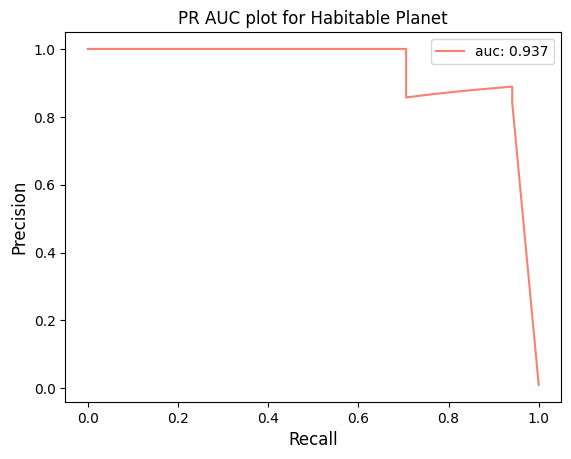

In [74]:
df_test_results, df_feature = test_model(df_test)

In [75]:
labels = df_test_results["label"]
proba = df_test_results["cali_proba"]
output = []
for x in proba:
    if x > 0.5:
        output.append(1)
    else:
        output.append(0)

print(classification_report(labels, output))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1654
           1       0.87      0.76      0.81        17

    accuracy                           1.00      1671
   macro avg       0.93      0.88      0.91      1671
weighted avg       1.00      1.00      1.00      1671



In [76]:
display(df_feature)

,importance,stddev,p_value,n,p99_high,p99_low
P_TEMP_SURF,0.845076,0.000000,0.500000,5,0.845076,0.845076
P_FLUX_MIN,0.067300,0.024213,0.001705,5,0.117154,0.017446
P_TEMP_EQUIL,0.060379,0.015149,0.000438,5,0.091571,0.029187
P_FLUX_MAX,0.006656,0.014883,0.186950,5,0.037300,-0.023988
P_MASS,0.000000,0.000000,0.500000,5,0.000000,0.000000
...,...,...,...,...,...,...
S_TYPE,0.000000,0.000000,0.500000,5,0.000000,0.000000
P_OMEGA_ERROR_MAX,0.000000,0.000000,0.500000,5,0.000000,0.000000
P_OMEGA_ERROR_MIN,0.000000,0.000000,0.500000,5,0.000000,0.000000
S_LOG_G_ERROR_MIN,-0.026231,0.014664,0.991935,5,0.003962,-0.056424


In [31]:
df_test_best = pd.read_csv("/Users/brihat/Washington/NumericalAnalysis/models_catboost_withoutESI/results/test.csv",sep=",")

In [63]:
labels = df_test_best["label"]
proba = df_test_best["cali_proba"]
output = []
for x in proba:
    if x > 0.5:
        output.append(1)
    else:
        output.append(0)

print(classification_report(labels, output))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1654
           1       0.94      0.88      0.91        17

    accuracy                           1.00      1671
   macro avg       0.97      0.94      0.95      1671
weighted avg       1.00      1.00      1.00      1671



In [64]:
print(confusion_matrix(labels, output))

[[1653    1]
 [   2   15]]


In [82]:
df_test_best_xgb = pd.read_csv("/Users/brihat/Washington/NumericalAnalysis/models_xgb_withoutESI/results/test.csv",sep=",")

In [79]:
def generatePRAUC_CURVE_v1(recall, precision, prauc, recall_1, precision_1, prauc_1):

    if not os.path.exists("models/plots"):
        os.makedirs("models/plots")

    r_rgb = (251, 128, 114)
    r_rgb = [x/256.0 for x in r_rgb]
    plt.figure()
    plt.plot(recall, precision, label="catboost: " + str(round(prauc, 3)), color=r_rgb)
    plt.plot(recall_1, precision_1, label="xgboost: " + str(round(prauc_1, 3)))
    plt.title("PR AUC plot for habitable planet detection models")
    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    plt.legend(fontsize=10)
    plt.legend()
    plt.savefig("models/plots/pr_auc_for_hab_planet.png", dpi=300)
    plt.show()

In [83]:
precision, recall,_ = precision_recall_curve(df_test_best["label"], df_test_best["cali_proba"])
auc_precision_recall = auc(recall, precision)
precision1, recall1,_ = precision_recall_curve(df_test_best_xgb["label"], df_test_best_xgb["cali_proba"])
auc_precision_recall_1 = auc(recall1, precision1)

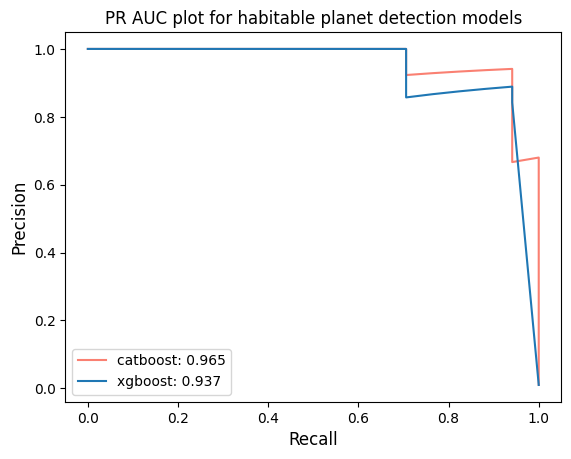

In [86]:
generatePRAUC_CURVE_v1(recall, precision, auc_precision_recall, recall1, precision1, auc_precision_recall_1)